In [1]:
from ultralytics import YOLO
import cv2
import math
import torch
import numpy as np

In [2]:
FIRE_WEIGHTS = "Models/Fire Detection/fire.pt"
WEAPONS_WEIGHTS = "Models/weapon Detection/best.pt"
VIOLENCE_WEIGHTS = "Models/Violence Detection/ViolenceDet.pt"

In [3]:
classes = {
    "generic": ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat",
              "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
              "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
              "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
              "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup",
              "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli",
              "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed",
              "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone",
              "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
              "teddy bear", "hair drier", "toothbrush"
              ],
    "fire" : ["fire","smoke"],
    "violence":["Violence","Weapons"],
    "weapons" : ["Grenade","Handgun","Rifle","Steel arms"]
    # "abduction":["Kidnap", "Non Kidnap"]
}

In [4]:
models = {}
models["generic"] = YOLO("yolov8n.pt")
models["fire"] = YOLO(FIRE_WEIGHTS)
models["weapons"] = YOLO(WEAPONS_WEIGHTS)
models["violence"] = YOLO(VIOLENCE_WEIGHTS)

In [5]:
import time

In [7]:
import numpy as np
import cv2
import pygame
import matplotlib.pyplot as plt
# Initialize pygame
pygame.mixer.init()

# Load siren sound
siren_sound = pygame.mixer.Sound('police-6007.mp3')

# Video capturing starts
def tampering(frame):
    # cap = cv2.VideoCapture(0)
    fgbg = cv2.createBackgroundSubtractorMOG2()
    # ret, frame = cap.read()
    fgmask = fgbg.apply(frame)
    kernel = np.ones((5,5), np.uint8)
    
    if frame is None:
        print("End of frame")
    else:
        a = 0
        bounding_rect = []
        fgmask = fgbg.apply(frame)
        fgmask = cv2.erode(fgmask, kernel, iterations=5) 
        fgmask = cv2.dilate(fgmask, kernel, iterations=5)
        cv2.imshow('frame', frame)
        contours, _ = cv2.findContours(fgmask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for i in range(len(contours)):
            bounding_rect.append(cv2.boundingRect(contours[i]))
        for i in range(len(contours)):
            if bounding_rect[i][2] >= 40 or bounding_rect[i][3] >= 40:
                a = a + (bounding_rect[i][2]) * bounding_rect[i][3]
            if a >= int(frame.shape[0]) * int(frame.shape[1]) / 3:
                cv2.putText(frame, "TAMPERING DETECTED", (5, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
                # Play siren sound
                siren_sound.play()
            cv2.imshow('frame', frame)

pygame 2.5.2 (SDL 2.28.3, Python 3.11.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [8]:
import pandas as pd
import os
def create_csv():
  try:
    df = pd.read_csv('anomalies.csv')
  except FileNotFoundError:
    df = pd.DataFrame(columns=['Timestamp','Type of anomaly' ,'Number of People present', 'Path of image'])
    df.to_csv('anomalies.csv', index=False)
  return df

def append_to_csv(df, timestamp, num_inmates, image_path, typeofanomaly=""):
  new_data = {'Timestamp': timestamp, 'Type of anomaly':typeofanomaly, 'Number of People present': num_inmates, 'Path of image': image_path}
  new_data_df = pd.DataFrame.from_dict(new_data, orient='index').T
  df = pd.concat([df, new_data_df], ignore_index=True)
  df.to_csv('anomalies.csv', index=False)

inmatesthresholdtime = 2
anomaly_count = {} 
df = create_csv()

def process_model(model, img, classNames, model_name, numinmates , savetodir="frames"):
    global inmatesthresholdtime, anomaly_count, df
    
    results = model(img, stream=True)
    inmates = 0
    anomalies = []
    typeofanomaly = {
            "generic": "crowd",
            "fire": "Fire",
            "weapons": "Weapons",
            "violence": "Violence",
  
        }
    for r in results:
        boxes = r.boxes
        for box in boxes:
            cls = int(box.cls[0])
            confidence = math.ceil((box.conf[0]*100))/100
            if confidence < 0.6:
                continue
            if cls >= len(classNames):
                print("Error: Class index out of range")
                continue
            accepted_list = ["person", "fire", "Grenade", "Handgun", "Rifle", "Steel arms","Violence","Kidnap", "Not Kidnap"]
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 255), 3)
            if model_name == "generic" and classNames[cls] == "person":
                inmates += 1
            if classNames[cls] in accepted_list:
                anomaly_key = (model_name, classNames[cls])
                anomaly_count[anomaly_key] = anomaly_count.get(anomaly_key, 0) + 1
                if anomaly_count[anomaly_key] >= 1:
                    timestamp = time.strftime('%Y-%m-%d %H:%M:%S') 
                    anomaly_text = f"{classNames[cls]} detected, storing the frame in the database as {savetodir}/{timestamp}.jpg at {timestamp}.\n"
                    print(anomaly_text)
                    anomalies.append(anomaly_text)
                    anomaly_count[anomaly_key] = 0
                    df = create_csv()
                    # if model_name == "generic" and inmates > numinmates:
                    #   append_to_csv(df, timestamp, inmates, f"{savetodir}/{timestamp}.jpg", typeofanomaly[model_name])
                    # elif model_name != "generic":
                    #   append_to_csv(df, timestamp, inmates, f"{savetodir}/{timestamp}.jpg", typeofanomaly[model_name])
                    with open("anomalies.txt", "a") as f:
                        f.write(anomaly_text)
                    # create the directory if it does not exist
                    if not os.path.exists(savetodir):
                        os.makedirs(savetodir)
                    cv2.imwrite(filename=savetodir+"/"+timestamp+".jpg", img=img)
                    
                    
            print("Confidence --->", confidence)
            print("Class name -->", classNames[cls])
            org = [x1, y1]
            font = cv2.FONT_HERSHEY_SIMPLEX
            fontScale = 1
            color = (255, 0, 0)
            thickness = 2
            cv2.putText(img, classNames[cls], org, font, fontScale, color, thickness)
            
    if inmatesthresholdtime <= 0:
        inmatesthresholdtime = 2
    else:
        inmatesthresholdtime -= 1

    with open("anomalies.txt", "a") as f:
        f.write(" ".join(anomalies) )

def start_webcam(models, classes):
  cap = cv2.VideoCapture(1)
  while True:
    ret, frame = cap.read()
    if not ret:
      print("Error: Unable to capture frame")
      break
    for model_name, model in models.items():
      process_model(model, frame.copy(), classes[model_name], model_name, 10)  # Pass a copy of frame to avoid modification across models
    cv2.imshow("frame", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break

  cap.release()
  cv2.destroyAllWindows()

In [9]:
# run the function on demo video
def start_demo(models, classes):
    cap = cv2.VideoCapture("Models/weapon Detection/gun.mp4")
    # cap = cv2.VideoCapture("fire1.mp4")

    i = 0
    while True:
        i += 1
        print(f"{i}th frame")
        ret, frame = cap.read()
        if i%10 != 0:
            continue
        if not ret:
            print("Error: Unable to capture frame")
            break
        if cv2.waitKey(1) & 0xFF == ord('q'):
                break 
        for model_name, model in models.items():
            anomaly_detected = process_model(model, frame.copy(), classes[model_name], model_name, 10)  # Pass a copy of frame to avoid modification across models
        if anomaly_detected:    
            try:
                tampering(frame)
            except Exception as e:
                print("An error occurred while tampering the image:", e)
            cv2.imshow("frame", frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    
    cap.release()
    cv2.destroyAllWindows()

In [10]:
start_demo(models, classes)


1th frame
2th frame
3th frame
4th frame
5th frame
6th frame
7th frame
8th frame
9th frame
10th frame

0: 384x640 (no detections), 78.9ms
Speed: 5.5ms preprocess, 78.9ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)

0: 256x448 (no detections), 102.5ms
Speed: 1.1ms preprocess, 102.5ms inference, 0.3ms postprocess per image at shape (1, 3, 256, 448)

0: 256x448 (no detections), 109.6ms
Speed: 0.7ms preprocess, 109.6ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 448)

0: 256x448 (no detections), 101.8ms
Speed: 1.0ms preprocess, 101.8ms inference, 0.2ms postprocess per image at shape (1, 3, 256, 448)
11th frame
12th frame
13th frame
14th frame
15th frame
16th frame
17th frame
18th frame
19th frame
20th frame

0: 384x640 (no detections), 65.4ms
Speed: 1.2ms preprocess, 65.4ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)

0: 256x448 (no detections), 97.7ms
Speed: 0.9ms preprocess, 97.7ms inference, 0.2ms postprocess per image at shape (1

In [76]:
import lida
from lida import llm, Manager, TextGenerationConfig
import pandas as pd
import os

In [40]:
os.environ["COHERE_API_KEY"] = "hk305qjjFaCIXME1dGS0OIIHDth4NFnTtuzpPCOg"

In [41]:
# Load your data (replace with your data source)
data = pd.read_csv("anomalies.csv")

lida = Manager(text_gen=llm("cohere"))  # Assuming llm is a function to create a LLM object
textgen_config = TextGenerationConfig(n=2, temperature=0.5, use_cache=True)  # Set n to 2 for 2 goals

try:
    # Summarize data with default method
    textgen_config.n = 1  # Set n to 1 for a single summary
    summary = lida.summarize(data=data, summary_method="default", textgen_config=textgen_config)

    # Define security guard persona
    persona = "I am a security guard at a prison. I want to be able to identify and respond to potential threats effectively based on prison anomaly data."

    # Generate goals based on summary and persona
    personal_goals = lida.goals(summary, n=2, persona=persona, textgen_config=textgen_config)

    # Display generated goals
    for goal in personal_goals:
        print(goal)

except Exception as e:
    print("Error:", e)

Goal(question='What is the distribution of anomalies by type?', visualization='Histogram of Type of anomaly', rationale='Visualizing the variety of anomalies can help you recognize anomaly trends and respond appropriately. Whether there are many photo anomalies and few person anomalies, a histogram can reveal these patterns ', index=0)
Goal(question='Are there any significant time differences between different types of anomalies?', visualization='Box plot of Timestamp by Type of anomaly', rationale='This will help you detect significant variations in timing. You could also note trends in early detection of anomalies to maximize response time', index=1)


 ```
import matplotlib.pyplot as plt
import pandas as pd

def plot(data: pd.DataFrame):
    # Convert date fields to date types and drop NaT values
    data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
    data = data[pd.notna(data['Timestamp'])]

    # Plot box plot of Timestamp by Type of anomaly
    plt.boxplot(data['Timestamp'], labels=data['Type of anomaly'], patch_artist=True)
    plt.xlabel('Timestamp')
    plt.ylabel('Type of anomaly')
    plt.title('Are there any significant time differences between different types of anomalies?')
    plt.legend(title='Types of anomalies')
    return plt

chart = plot(data)
```
****
 Dimensions of labels and X must be compatible


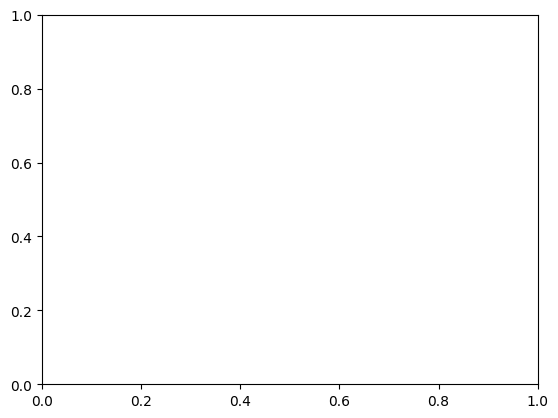

In [42]:
i = 0
library = "matplotlib"

charts = lida.visualize(summary=summary, goal=goal, textgen_config=textgen_config, library=library)  

for chart in charts:
    try:
        chart.show()
    except Exception as e:
        print(e)

In [43]:
from langchain_community.chat_models.huggingface import ChatHuggingFace
from langchain.prompts import PromptTemplate
from langchain_community.llms.huggingface_hub import HuggingFaceHub
from langchain.schema import HumanMessage
import os
from dotenv import get_key

os.environ["HUGGINGFACEHUB_API_TOKEN"] = get_key(key_to_get="HUGGINGFACEHUB_API_KEY",dotenv_path=".env")

# llm = HuggingFaceHub(
#     repo_id="HuggingFaceH4/zephyr-7b-beta",
#     task="text-generation",
#     model_kwargs={
#         "max_new_tokens": 512,
#         "top_k": 30,
#         "temperature": 0.5,
#         "repetition_penalty": 1.03,
#     },
# )
mixtral_llm = HuggingFaceHub(repo_id="mistralai/Mixtral-8x7B-Instruct-v0.1",model_kwargs={"temperature":0.3, "max_length": 100})

def chatwithbot(txt:str):
    prompt = PromptTemplate(template= "You're a helpful security assistant. You've been asked to help authorities. They want to be able to detect securty concerns in the city. They've provided you with a list of anomalies in the city with type of anomaly and timestamp.Answer questions of user from given data. Here's the data:\n{data}. \n\nUSERS QUERY:{input}", input_variables=["data","input"])

    # get the data from anomalies.txt
    with open("anomalies.txt", "r") as f:
        data = f.read()
    if len(data) == 0:
        data = "No anomalies detected"

    prompt_template = prompt.format(data=data,input=txt)


    chat_model = ChatHuggingFace(llm=mixtral_llm)
    messages =[
        HumanMessage(prompt_template),
    ]

    res = chat_model.invoke(messages)
    print(res.content)
    return res
    # res = res[res.find("<|assistant|>")+len("<|assistant|>"):]


In [44]:

def chat():
    while True:
        txt = input("Enter your message: ")
        if txt == "exit":
            break
        res = chatwithbot(txt)
        print(res)

In [29]:
chat()

LocalTokenNotFoundError: Token is required (`token=True`), but no token found. You need to provide a token or be logged in to Hugging Face with `huggingface-cli login` or `huggingface_hub.login`. See https://huggingface.co/settings/tokens.

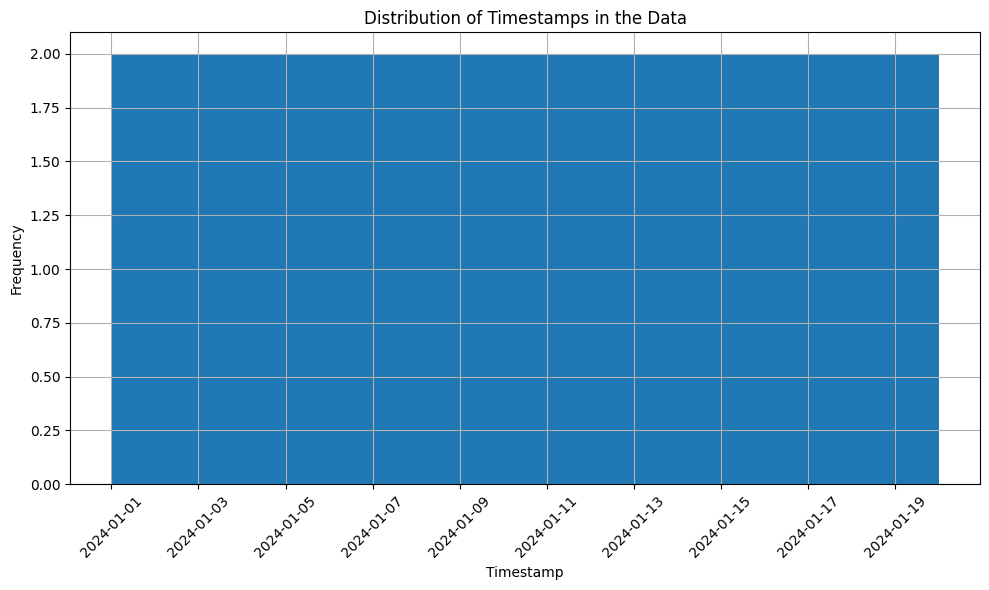

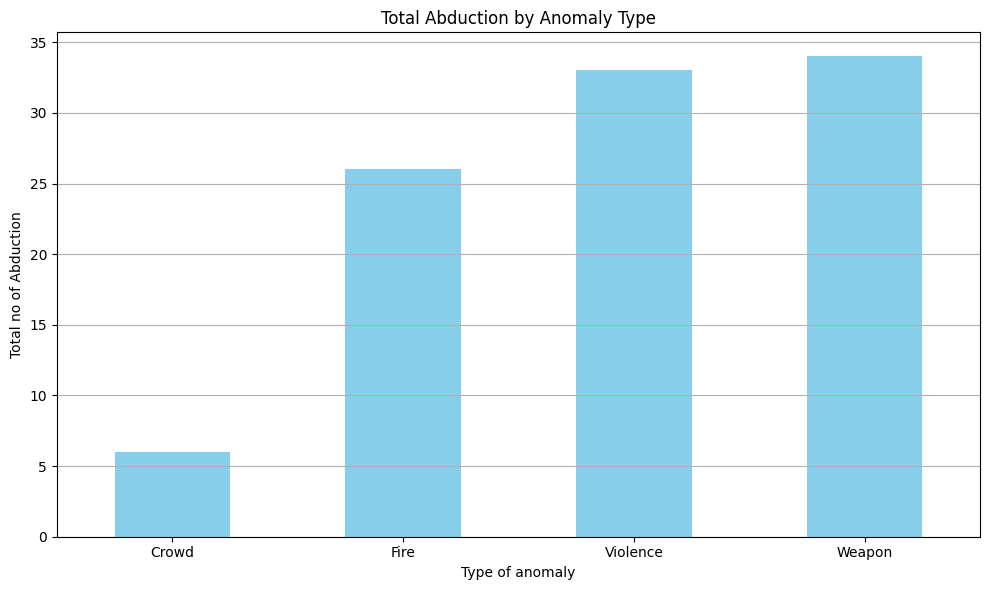